# Test ResNet50 Architcture

# Importing Libraries

In [1]:
import os
from pathlib import Path

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install pandas

In [4]:
!pip install matplotlib

In [5]:
!pip install sklearn

In [6]:
!pip install scikit-learn

In [7]:
# For opening, manipulating, and saving different image file formats
!pip install pillow

In [8]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

%matplotlib inline

# Designing a Convolution Neural Network (CNN): LeNet

In [9]:
import torch
import torch.nn as nn

# Define a block class that inherits from nn.Module
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        # Define convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()
        # Pass input through the convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        # Apply identity downsample if provided
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        # Add the identity (skip connection) to the output of convolutional layers
        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

         # Residual layers (layer1 to layer4)
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=1, num_classes=3):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def test():
    BATCH_SIZE = 32
    device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
    net = ResNet50(img_channel=1, num_classes=3).to(device)
    y = net(torch.randn(BATCH_SIZE, 1, 224, 224)).to(device)
    assert y.size() == torch.Size([BATCH_SIZE, 3])
    print(y.size())

In [10]:
model = ResNet50()
print(model)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [11]:
model.load_state_dict(torch.load(r"C:\Users\HP\Desktop\Model\ResNet50\ResNet50_With_Aug\ResNet50_Updated.pth", map_location={'cuda:0': 'cpu'}))

model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [12]:
from PIL import Image

In [ ]:
def make_prediction(image_path):
    # Open the image and convert it to grayscale
    image = Image.open(image_path).convert("L")
    pretrained_size = 224
    pretrained_means = [0.5]
    pretrained_stds = [0.5]

    # Define the transformation pipeline for the image
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to (224, 224)
        transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize((0.5), (0.5)),  # Normalize the image
    ])

    # Apply the transformations to the image
    image = train_transforms(image)

    # Reshape the image to match the expected input shape of the model
    image = image.reshape(1, 1, 224, 224)

    # Make predictions using the model
    predict = model(image)

    # Apply softmax activation to get the probabilities
    softmax = nn.Softmax(dim=1)
    predict = softmax(predict)

    # Get the maximum probability and corresponding prediction
    probability, prediction = torch.max(predict, dim=1)

    # Convert the torch tensors to numpy arrays
    probability = probability.detach().numpy()[0]
    prediction = prediction.detach().numpy()[0]

    return probability, prediction


In [15]:
# make_prediciton(test_dataset[0][0])

In [14]:
make_prediciton(r"C:\Users\HP\Desktop\Model\DATASET\Testing\malignant\malignant (47).png")

(0.9983322, 1)

In [15]:
make_prediciton(r"C:\Users\HP\Desktop\Model\DATASET\Testing\benign\benign (1).png")

(1.0, 0)

In [16]:
#Misclassify
make_prediciton(r"C:\Users\HP\Desktop\Model\DATASET\Testing\normal\normal (15).png")

(0.9957925, 0)

In [17]:
make_prediciton(r"C:\Users\HP\Desktop\Model\DATASET\Testing\normal\normal (1).png")

(0.92811245, 2)

In [18]:
# Hyper parameters
epochs = 30
num_classes = 3
batch_size = 32
learning_rate = 0.001


In [19]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [20]:
test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])


valid_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])

In [21]:
test_dataset = torchvision.datasets.ImageFolder(root= r"C:\Users\HP\Desktop\Model\DATASET\Testing", transform = test_transforms)
# test_dataset = torchvision.datasets.ImageFolder(root= r"C:\Users\HP\Desktop\Model\DATASET", transform = test_transforms)

In [22]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 155
    Root location: C:\Users\HP\Desktop\Model\DATASET\Testing
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [23]:
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

In [24]:
from tqdm import tqdm

In [25]:
test_dataset[100]

(tensor([[[-0.9529, -0.9137, -0.9216,  ..., -0.6392, -0.9608, -0.9843],
          [-0.9451, -0.9216, -0.9059,  ..., -0.5922, -0.9059, -0.9922],
          [-0.9608, -0.9373, -0.9373,  ..., -0.5922, -0.7882, -0.9765],
          ...,
          [-0.9451, -0.9373, -0.9294,  ..., -0.9137, -0.9137, -0.9059],
          [-0.9373, -0.9451, -0.9451,  ..., -0.8980, -0.9137, -0.9373],
          [-0.9294, -0.9373, -0.9373,  ..., -0.8980, -0.9216, -0.9137]]]),
 1)

In [ ]:
# List to store predicted labels
preds = []  
# List to store true labels
target = [] 
# List to store output probabilities for each class
probabilities = []  
# List to store individual probabilities for each prediction
individual_prob = []  

# Iterate over the test loader using tqdm for progress tracking
for images, labels in tqdm(test_loader):
    images = images.to(device)  # Move images to the specified device (GPU)
    labels = labels.to(device)  # Move labels to the specified device

    # Perform forward pass through the model
    outputs = model(images)

    # Apply softmax activation to the outputs to get probabilities
    outputs = nn.Softmax(dim=1)(outputs)

    # Get the maximum probability and corresponding predicted labels
    prob, predicted = torch.max(outputs.data, 1)

    # Convert predicted labels from GPU to CPU by converting PyTorch tensor to NumPy array
    predicted = predicted.cpu().numpy()

    # Convert outputs, probabilities, and true labels from GPU to CPU and convert them to NumPy arrays
    outputs = outputs.cpu().detach().numpy()
    prob = prob.cpu().detach().numpy()
    labels = labels.cpu().numpy()

    # Append the predicted labels, true labels, output probabilities, and individual probabilities to their respective lists
    preds.append(predicted)
    target.append(labels)
    probabilities.append(list(outputs))
    individual_prob.append(list(prob))


Converting 2-D into 1-D array

In [27]:
probabilities1 = []
individual_prob1 = []
preds1 = []
target1 = []
#Converting 2-D into 1-D array
for i in probabilities:
  for j in i:
    probabilities1.append(j)

for i in individual_prob:
  for j in i:
    individual_prob1.append(j)
    
for i in preds:
  for j in i:
    preds1.append(j)
    
for i in target:
  for j in i:
    target1.append(j)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [29]:
accuracy_score(target1,preds1)

0.8838709677419355

In [30]:
print(classification_report(target1,preds1))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        87
           1       0.83      0.81      0.82        42
           2       0.96      0.85      0.90        26

    accuracy                           0.88       155
   macro avg       0.89      0.86      0.88       155
weighted avg       0.88      0.88      0.88       155



In [31]:
confusion_matrix(target1,preds1)

array([[81,  6,  0],
       [ 7, 34,  1],
       [ 3,  1, 22]], dtype=int64)

In [32]:
import matplotlib.pyplot as plt
import numpy
from sklearn .metrics import roc_auc_score, roc_curve
import seaborn as sns


In [33]:
test_dataset.classes

['benign', 'malignant', 'normal']

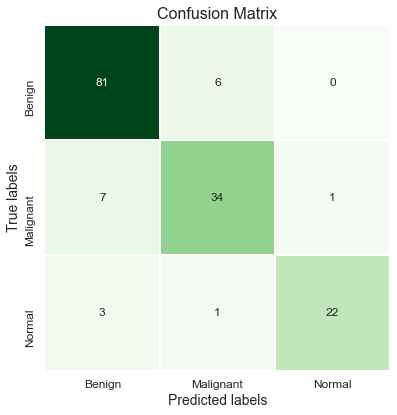

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_cm(confusion):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Greens", square=True, 
                cbar=False, annot_kws={"size": 12}, linewidths=0.5)
    plt.xlabel('Predicted labels', fontsize=14)
    plt.ylabel('True labels', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    classes = ['Benign', 'Malignant', 'Normal'] 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks + 0.5, classes, fontsize=12)
    plt.yticks(tick_marks + 0.5, classes, fontsize=12)
    plt.tight_layout()
    plt.show()

from sklearn.metrics import confusion_matrix

# Assuming target1 and preds1 are the true labels and predicted labels, respectively
confusion = confusion_matrix(target1, preds1, labels=[0, 1, 2])
plot_cm(confusion)


In [35]:
auc = np.round(roc_auc_score(target1, probabilities1, multi_class = 'ovr'), 3)
print("Auc score for our sample data is {}". format(auc))

Auc score for our sample data is 0.972


In [36]:
probabilities2 = np.array([i for i in probabilities1])

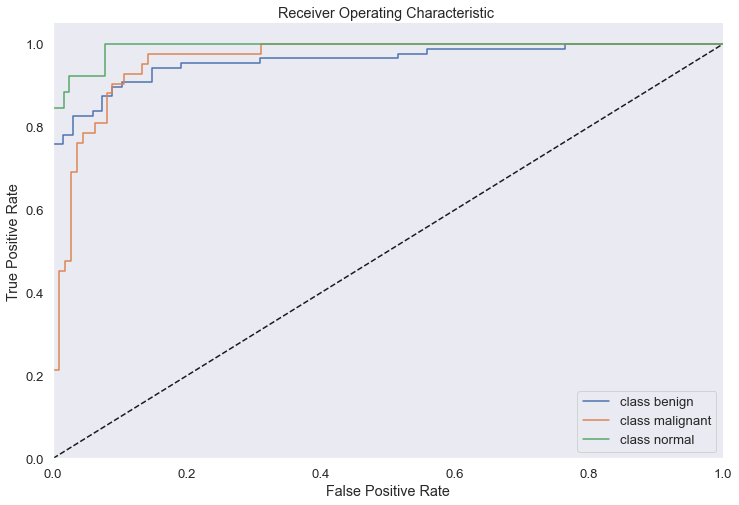

In [37]:
def plot_multiclass_roc(y_score, y_test, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    threshold = dict()

    for i in range(n_classes):    
      fpr[i], tpr[i], threshold[i] = roc_curve(target1, probabilities2[:,i], pos_label=i)
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic ')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label = 'class '+ test_dataset.classes[i])
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(probabilities2, target1, n_classes=3, figsize=(12,8))